# Clustering des causes de retard

In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Data Preparation

In [26]:
data_path = 'data.csv'
data = pd.read_csv(data_path, sep=';')

# On retire les lignes où les sommes des pourcentages ne fait pas 1 (données mal renseignées)
features_cause = [col for col in data.columns if col.startswith('prct')]
somme_pourcentage=data[features_cause].sum(axis=1)
data = data.loc[(somme_pourcentage >= 99.9) & (somme_pourcentage <= 100.1)]


In [5]:
data_path = 'data.csv'
data = pd.read_csv(data_path, sep=';')

# On retire les lignes où les sommes des pourcentages ne fait pas 1 (données mal renseignées)
features_cause = [col for col in data.columns if col.startswith('prct')]
somme_pourcentage=data[features_cause].sum(axis=1)
data = data.loc[(somme_pourcentage >= 99.9) & (somme_pourcentage <= 100.1)]


data['couple_gares'] = [f"{row.gare_depart}-{row.gare_arrivee}" for row in data.itertuples()]

In [6]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].apply(lambda time: time.year)
data['month'] = data['date'].apply(lambda time: time.month)

data_clustering = data[data['year'] < 2023]

In [9]:
data_clustering = data_clustering.groupby('couple_gares').agg({'prct_cause_externe': 'mean',
                                         'prct_cause_infra': 'mean',
                                         'prct_cause_gestion_trafic': 'mean',
                                         'prct_cause_materiel_roulant': 'mean',
                                         'prct_cause_gestion_gare': 'mean',
                                         'prct_cause_prise_en_charge_voyageurs': 'mean'}).reset_index()

## K-Means fitting

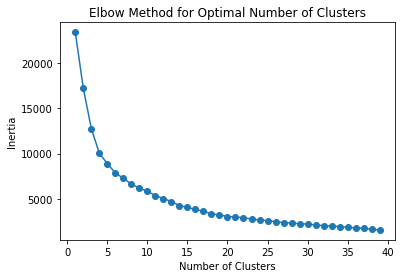

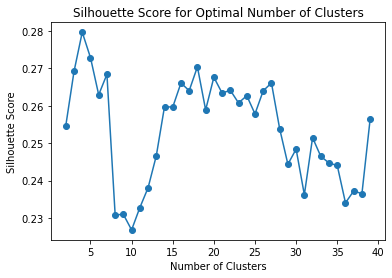

In [12]:
inertia = []

# Define a range of cluster numbers to test
cluster_range = range(1, 40)

# Calculate inertia for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Create an empty list to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
cluster_range = range(2, 40)  # Start with a minimum of 2 clusters

# Calculate silhouette scores for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
    silhouette_avg = silhouette_score(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

The elbow rule recommends fitting the KMeans algo on n_clusters = 6 or 7. The Silhouette Score highly recommends n_clusters = 4 or 18. -> This will be our ultimate choice.

In [13]:
# Fit k-means on 18 clusters
kmeans = KMeans(n_clusters=18)
cluster_labels = kmeans.fit_predict(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
data_clustering['cluster'] = cluster_labels

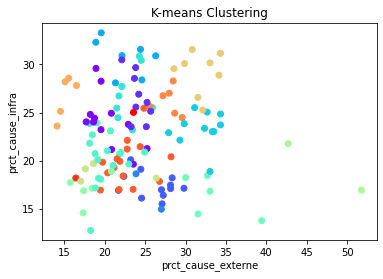

In [14]:
# Plot the data and cluster centers
plt.scatter(data_clustering['prct_cause_externe'], data_clustering['prct_cause_infra'], c=data_clustering['cluster'], cmap='rainbow')
plt.xlabel('prct_cause_externe')
plt.ylabel('prct_cause_infra')
plt.title('K-means Clustering')
plt.show()

In [15]:
cluster_centers = kmeans.cluster_centers_

In [16]:
n_components = 2  # Adjust this to the number of components you need
pca = PCA(n_components=n_components)

# Fit and transform the cluster centroids
cluster_centers_pca = pca.fit_transform(cluster_centers)

# The result, 'cluster_centers_pca', contains the PCA-transformed coordinates of the cluster centroids
print(cluster_centers_pca)

[[ -8.6578774   -7.37467633]
 [ -8.75329024   0.30824709]
 [ -1.14043198   1.17969705]
 [ 15.61644964  -1.81701874]
 [ -3.02757026   0.50431321]
 [ -4.19699011   8.75632654]
 [  2.42957302  -0.86590901]
 [ -3.39523735  -5.74022668]
 [ 14.0049796    8.62098077]
 [ 11.51960606  -8.5927099 ]
 [ -5.82238648  23.51253639]
 [-19.73763276 -11.93217683]
 [-11.08303881   9.5353009 ]
 [  8.17153951  -8.12315   ]
 [ -7.51030277   3.30145072]
 [-11.99556213  -5.09613635]
 [  4.74231108  -7.59260457]
 [ 28.83586138   1.41575574]]


In [17]:
new_points = pca.transform(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
new_points_x, new_points_y = new_points[:,0], new_points[:, 1]

In [18]:
data_clustering['projection_x'] = new_points_x
data_clustering['projection_y'] = new_points_y

In [19]:
data_clustering.head()
data_clustering.to_csv("./data_clustering.csv", sep=";")

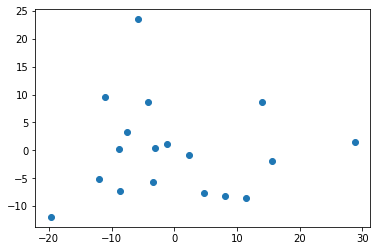

In [20]:
plt.scatter(cluster_centers_pca[:,0], cluster_centers_pca[:, 1])

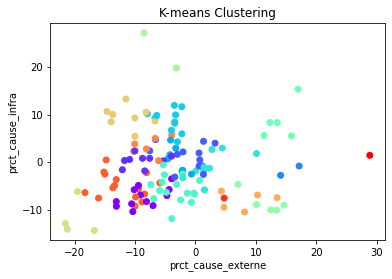

In [21]:
# Plot the data and cluster centers
plt.scatter(data_clustering['projection_x'], data_clustering['projection_y'], c=data_clustering['cluster'], cmap='rainbow')
plt.xlabel('prct_cause_externe')
plt.ylabel('prct_cause_infra')
plt.title('K-means Clustering')
plt.show()